In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import PIL
import random
import os
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Data Preprocessing

In [168]:
data_dir = Path(r"C:\Users\ADMIN\Desktop\Brain Tumor Using CNN\brain_tumor_dataset")

In [169]:
yes = list(data_dir.glob('**/yes/*.jpg'))
no = list(data_dir.glob('**/no/*.jpg'))

In [170]:
print(len(yes))

154


In [171]:
print(len(no))

91


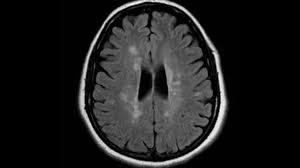

In [172]:
PIL.Image.open(str(no[3]))

In [173]:
brain_img_dict = {
    'yes': yes,
    'no': no
}

In [174]:
labels ={
    'yes': 1,
    'no': 0
}

In [175]:
x, y = [], []
for image_name, images in brain_img_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        canny = cv2.Canny(img, 100, 200)
        img_resize = cv2.resize(canny, (512, 512))
        img_resize = np.expand_dims(img_resize, axis=-1)
        x.append(img_resize)
        y.append(labels[image_name])

# Dataset Splitting

In [176]:
x = np.array(x, dtype='float32')
y = np.array(y, dtype='float32')

In [177]:
x[1].shape

(512, 512, 1)

In [178]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y,
                                                    test_size = 0.2,
                                                    random_state=42,
                                                    stratify= y)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp,
                                                test_size = 0.5,
                                                random_state=42,
                                                stratify=y_temp)

# TensorFlow Dataset Pipeline

In [179]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [180]:
len(test_ds)

25

In [181]:
batch_size = 8

train_ds = (
    train_ds
    .shuffle(buffer_size=len(x_train))
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = val_ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

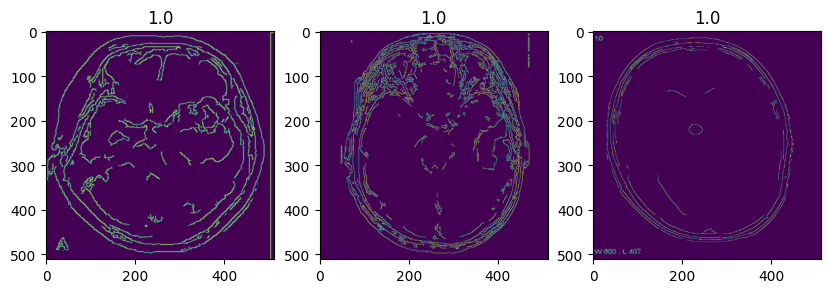

In [182]:
for image_batch, batch_label in train_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(3):
        ax = plt.subplot(1, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(batch_label[i].numpy())

In [183]:
for image_batch, batch_label in test_ds.take(1):
    print(image_batch.shape, image_batch.dtype)

(8, 512, 512, 1) <dtype: 'float32'>


# Data Augmentation

In [184]:
rescale = tf.keras.Sequential([
    layers.Rescaling(1.0/255)
])

In [185]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

# Model Building

In [188]:
model = models.Sequential([
    # augmentation
    rescale,
    data_augmentation,

    # CNN Layer
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = (8, 512, 512, 1)),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    #Dense Neural Network
    layers.Flatten(),
    layers.Dense(64, activation ='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [189]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [190]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [201]:
history = model.fit(train_ds,
         validation_data=val_ds,
         batch_size=8,
         verbose=1,
         epochs=50,
         callbacks=[early_stop]          )

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - accuracy: 0.7969 - loss: 0.4454 - val_accuracy: 0.7917 - val_loss: 0.5383
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 445ms/step - accuracy: 0.7760 - loss: 0.4727 - val_accuracy: 0.7917 - val_loss: 0.5357
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 472ms/step - accuracy: 0.7812 - loss: 0.4520 - val_accuracy: 0.8333 - val_loss: 0.5139
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 524ms/step - accuracy: 0.7812 - loss: 0.4435 - val_accuracy: 0.7500 - val_loss: 0.5382
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 521ms/step - accuracy: 0.7917 - loss: 0.4535 - val_accuracy: 0.7500 - val_loss: 0.5244


# Model Evaluation

In [202]:
model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8750 - loss: 0.2860


[0.28598546981811523, 0.875]

In [203]:
# Get predictions (probabilities between 0 and 1)
Predicted_batch = model.predict(test_ds)

# Convert probabilities to binary (0 or 1)
y_predicted = (Predicted_batch > 0.5).astype("int32").flatten()

# Optional: convert numeric to label name if you want text output
label_map_reverse = {0: 'no', 1: 'yes'}
y_predicted_labels = [label_map_reverse[val] for val in y_predicted]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


In [204]:
y_true = []
y_true_numerical = []
for image_batch, label_batch in test_ds:
    for label in label_batch:
        y_true.append(label_map_reverse[int(label)])
        y_true_numerical.append(int(label))

## Confusion Matrix

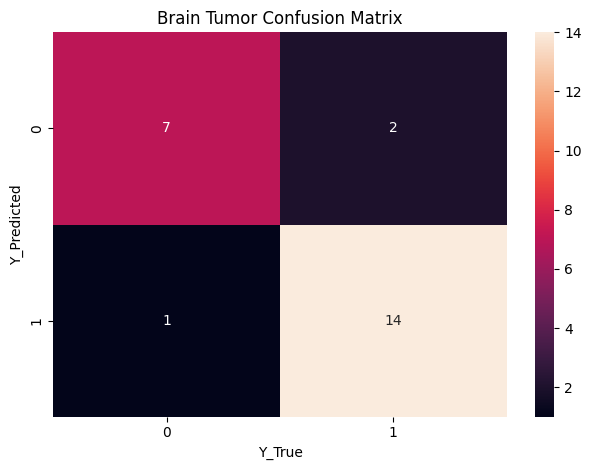

In [205]:
cm  = confusion_matrix(y_true, y_predicted_labels)
sns.heatmap(cm, annot = True)
plt.xlabel('Y_True')
plt.ylabel('Y_Predicted')
plt.title('Brain Tumor Confusion Matrix')
plt.tight_layout()
plt.show()

## Classification Report

In [206]:
print(classification_report(y_true, y_predicted_labels))

              precision    recall  f1-score   support

          no       0.88      0.78      0.82         9
         yes       0.88      0.93      0.90        15

    accuracy                           0.88        24
   macro avg       0.88      0.86      0.86        24
weighted avg       0.88      0.88      0.87        24



## Validation and Training Loss and Accuracy

In [207]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [208]:
accuracy = history.history['accuracy']
loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

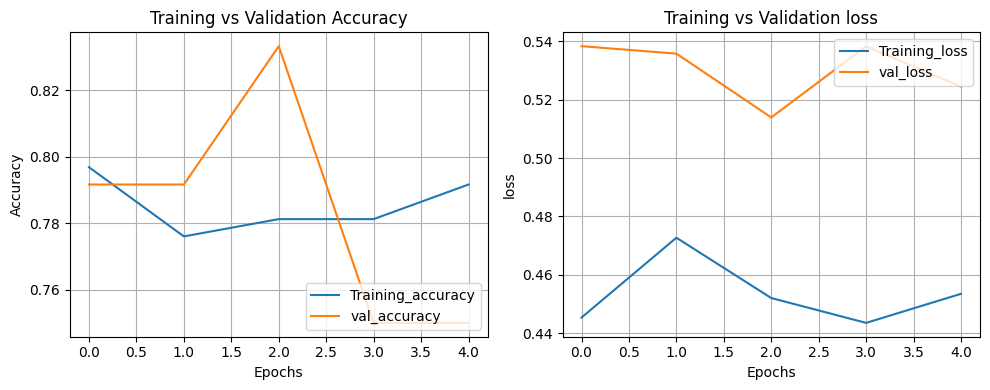

In [209]:
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label = 'Training_accuracy')
plt.plot(val_accuracy, label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training vs Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(loss, label = 'Training_loss')
plt.plot(val_loss, label = 'val_loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(loc = 'upper right')
plt.title('Training vs Validation loss')

plt.grid()

plt.tight_layout()

## ROC-AUC Score

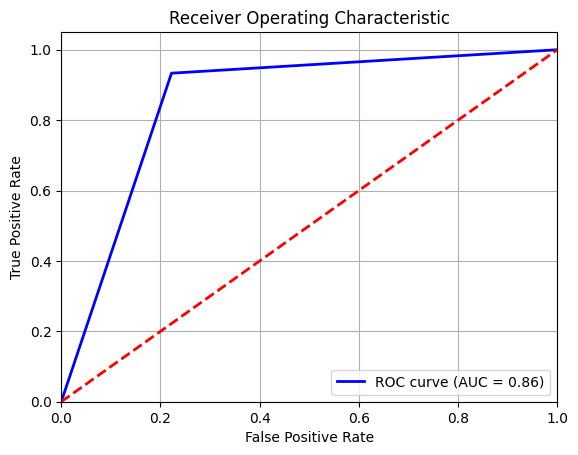

In [210]:
fpr, tpr, thresholds = roc_curve(y_true_numerical, y_predicted)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()